# Learning Quadrotor Flight Control Tasks Using Deep Reinforcement Learning

## 1. Introduction

### 1.1 Contributions
This work makes the following contributions:
1. We provide a free-to-use framework that extends OpenAI Gym, designed for training quadrotor flight control tasks.
2. We conduct the largest survey we know of, of techniques for improving the learning of quadrotor flight controllers. Whilst some of these results are known (for example, the poor performance of DDPG in continuous-action flight control []) ours is the first work to explicitly test online versus offline learning in this domain.
3. We show that linearizing the action around hover RPM is an effective means of learning good performance, but that this can result in the agent not effectively utilizing the action space. We test other action-selection methods and show that they can and do make better use of the action space.
4. We test the effects of including time and bootstrapping in the learning process. Other works (e.g. []) have used bootstrapping, but did not test whether or not this improved the learned policy. We show that in this domain, it is important. Furthermore, ours is the first work to include time in the observation space, which gives us more general flight controllers than previous works (i.e. we are able to modulate their flight speed).

## 2. Related Work
\cite{c7,c9} used MPC-Guided Policy Search to learn to fly a quadrotor in Gazebo through unstructured environments using LIDAR. This was done using a heavily modified fork of RotorS \cite{c8}, with a custom control node running the policy search algorithm. This research proved the efficacy of using RL to train continuous-action controllers for quadrotors.

\cite{c10} used a method similar to guided policy search to train a quadrotor controller to avoid collisions in obstacle-filled environments. In order to overcome the relative sparsity of such events, \cite{c10} used a novel sampling strategy to overexpose the agent to collisions, resulting in a more risk averse policy. The authors successfully tested the learned policy on the CrazyFlie nanoquad using a native C-library for the network weights.

\cite{c6} used a custom natural policy gradient method to recover a tumbling aircraft. To do this, the authors used a novel "junction" exploration strategy, and wrote a very simple flight dynamics model -- omitting the effects of drag -- to demonstrate that they could still learn robust control policies using deep RL. The policies were successfully tested on a real-world aircraft using a Vicon camera system for state estimation. Despite their impressive results, their algorithm did not demonstrate any sample efficiency improvements over TRPO, with the main gains being due to their exploration strategy running many trajectories in parallel. It's not clear that this strategy couldn't also be used with TRPO. Furthermore, they used a PD controller to guide the search, and do not specify whether or not this modification was also used for TRPO and DDPG. This is 

These previous studies are typically constrained to a single task, and -- in the case of \cite{c6,c7,c9,c10} -- make use of an expert to guide learning. In \cite{c7,c9,c10}, a trajectory planner was used to turn the task of policy search into a supervised learning task, whereas in \cite{c6}, a PD controller was used to help stabilize learning (though the final policy did not use the controller, and far exceeded its capabilities). Our work does not make use of such additional machinery, and learns the policy directly. Furthermore, we learn controllers for a greater number of tasks than these previous works.

Surprisingly, no work that we know of has explicitly attempted training current state-of-the-art algorithms without any additional aids; [] comes the closest, but used a PD controller to bias the policy search algorithm in the direction of the solution, and make no mention of whether this was done for their implementations of TRPO and DDPG. Other works have reported that DDPG struggles to learn continuous flight control tasks \cite{c6}, but no works have attempted using REINFORCE with GAE, or PPO, for the problem of continuous-action flight control. Given that PPO and TRPO are state-of-the-art algorithms with notable success in continuous-action control tasks -- and, more recently -- DOTA2 and StarCraft II \cite{c11}, it stands to reason that such algorithms should be able to learn simple flight control tasks.

## 3. Background

### 3.1 Policy Search
We assume a Markov Decision Process with continuous states $s \in \mathcal{S}$ and continuous actions $a \in \mathcal{A}$. We denote a trajectory $\tau$ as an ordered set of events $\{s_{0}, a_{0}, r_{0}, ...,s_{H-1},a_{H-1}, r_{H-1},s_{H}\}$ from time $0 \leq t \leq H$, for states and actions distributed according to a policy $\pi$, and rewards $r \in \mathcal{R}$ from the environment \cite{c12}.

The goal of our agent is to maximize a gamma-discounted sum of rewards over time:

\begin{equation}
	G_{t} = r_{0} +\gamma r_{1} + \gamma^{2} r_{2} + ... + \gamma^{H} r_{H} =  \sum_{i=0}^{H} \gamma^{i}r_{t+i+1}
\end{equation}

Where $H$ can be either a finite or infinite horizon, and $\gamma \in [0, 1]$ is a discount factor that ensures that $G_{t}$ converges for $H=\infty$.

The state and state-action value functions of policy $\pi$ are defined as:

\begin{equation}
	V^{\pi}(s_{t}) = \mathbb{E}_{\pi}\left[\sum_{i=0}^{H} \gamma^{i}r_{t+i+1}|s_{t}=s\right]
\end{equation}

\begin{equation}
	Q^{\pi}(s_{t}, a_{t}) = \mathbb{E}_{\pi}\left[\sum_{i=0}^{H} \gamma^{i}r_{t+i+1}|s_{t}=s, a_{t}=a\right]
\end{equation}

With the advantage function of $\pi$ being:

\begin{equation}
    A^{\pi}(s_{t},a_{t})=Q^{\pi}(s_{t},a_{t})-V^{\pi}(s_{t})
\end{equation}

Our policy is a stochastic function $\pi: \mathcal{S} \rightarrow \mathcal{A}$, and our goal is to find a set of policy weights $\theta$ that maximizes the expected return over trajectories sampled under $\pi$. 

We focus on the class of methods known as Monte-Carlo Policy Gradients, for which the policy selects actions, and a learned value function of the form $V:\mathcal{S} \rightarrow \mathbb{R}$ evaluates the resulting state. The value function is typically trained by minimizing the error:

\begin{equation}
\label{eqn:td_err}
    \mathcal{L}(\phi) = \mathbb{E}_{\pi}\left[\left(r_{t}+\gamma \hat{V}^{\pi}(s_{t+1})-V_{\phi}^{\pi}(s_{t})\right)^{2}\right]
\end{equation}

In which $\hat{V}^{\pi}$ refers to the Monte-Carlo estimate of $V^{\pi}$, and $V_{\phi}^{\pi}$ corresponds to the value function estimate parameterized by $\phi$. Gradient ascent is used to maximize the return of the policy by ascending the value function, using a stochastic gradient estimator:

\begin{equation}
\nabla_{\theta}\mathcal{L}(\theta)=\mathbb{E}_{\pi}\left[\sum_{t=0}^{H-1}\nabla_{\theta} \log \pi_{\theta}(a_{t}|s_{t})f^{\pi}(s_{t},a_{t})\right]
\end{equation}

 to learn on-policy \cite{c12,c13}, or using an importance sampling estimator:
 
\begin{equation}
\nabla_{\theta} \mathcal{L}(\theta) = \mathbb{E}_{\beta}\left[\sum_{t=0}^{H-1}\frac{\nabla_{\theta}\pi_{\theta}(a_{t}|s_{t})}{\mu(a_{t}|s_{t})}f^{\mu}(s_{t},a_{t})\right]\end{equation}

to learn off-policy \cite{c12,c14,c15}. $f^{\pi}(s_{t},a_{t})$ can take multiple forms (see \cite{c16}) but typically takes the form $r_{t}+\gamma \hat{V}^{\pi}(s_{t+1})-V_{\phi}^{\pi}(s_{t})$, or interpolates between the one-step and infinite horizon using an additional weighting (see TD($\lambda$) and generalized advantage estimation \cite{c16}). 

State-of-the-art policy gradient methods such as PPO and TRPO \cite{c17,c18} use the importance sampling estimator for on-policy learning, by bounding the update to a trust region over multiple update steps. The reason for this is that when updating the policy, we aim to take small steps, but small steps in the parameter space may not correspond to small steps in the action space. TRPO and PPO restrict the KL-Divergence between the old and new policies, which in theory guarantees monotonic policy improvement.

PPO is a first-order method that approximates the constrained second-order update used in TRPO, by using either a clipped objective, or an adaptive penalty based on the KL-divergence. Such methods typically use generalized advantage estimation to update the policy. Per the definition of the value function, $V^{\pi}(s_{t}) \neq V^{\mu}(s_{t})$ for arbitrary policies $\pi$ and $\mu$ \cite{c14}, and so an off-policy correction should be made when taking multiple gradient steps using a single roll-out batch.

We can produce more flexible controllers by using goal-conditioned policies, for which a goal is passed as contextual input to $\pi$ \cite{c19,c20}.  Similarly, a value function that takes an additional goal argument is a universal value function approximator (UVFA) \cite{c21}. Such value functions can estimate the value of states or state-action pairs given the context of the goal, making them useful for learning more general policies. Our research focuses on goal-conditioned policies as we aim to learn general flight control policies. 

### 3.2 Quadrotor Flight Dynamics
We briefly cover quadrotor flight dynamics here as it pertains to the learning problem.

Our aircraft is modeled in a NED axis system, and we use the full 6DOF nonlinear equations of motion:

\begin{equation}
    \begin{bmatrix}
		0 \\
		\mathbf{\dot{v}} \\
	\end{bmatrix} = 
	\begin{bmatrix}
		0 \\
		\mathbf{a}_{b}
	\end{bmatrix}
	+\mathbf{q}\otimes
	\begin{bmatrix}
		0 \\
		\mathbf{G}_{i}
	\end{bmatrix}\otimes
	\mathbf{q}^{-1}
	-\begin{bmatrix}
		0 \\
		\mathbf{\omega} \times \mathbf{v}
	\end{bmatrix}
\end{equation}

\begin{equation}
	\mathbf{\dot{\omega}} = \mathbf{J}^{-1}(\mathbf{M}_{b}-\mathbf{\omega}\times \mathbf{J}\mathbf{\omega})
\end{equation}

\begin{equation}	
	\begin{bmatrix}
		0 \\
		\mathbf{\dot{x}}
	\end{bmatrix} = \mathbf{q}^{-1} \otimes 
	\begin{bmatrix}
		0 \\
		\mathbf{v}
	\end{bmatrix} \otimes
	\mathbf{q}
\end{equation}

\begin{equation}
    \mathbf{\dot{q}} = -\frac{1}{2}
    \begin{bmatrix}
		0 \\\omega 
	\end{bmatrix}\otimes\mathbf{q}
\end{equation}

We model the motor thrust and torque as being $\propto \Omega^2$, with motor lag characterized by a linear first-order ODE:

\begin{equation}
\dot{\Omega} = -k_{\Omega}(\Omega-\Omega_{C})
\end{equation}

We include a simple aerodynamic force and moment model:

\begin{equation}
F_A = -k_F \mathbf{v}^T \mathbf{v} \hat{\mathbf{v}}
\end{equation}

\begin{equation}
Q_A = -k_Q \mathbf{v}^T \mathbf{v} \hat{\mathbf{v}}
\end{equation}

Our model is implemented in C++, with code generated using MATLAB Simulink. We wrote Python wrappers for the code so that we could interface it with standard Python ML libraries such as PyTorch, and test our own agents on standard benchmarks. We did this as we found that existing packages such as AirSim and Gazebo were unsuited to training agents at speeds faster than real-time, and that their decentralized nature made controlling action-selection frequency difficult (and largely dependent on hardware). Furthermore, previous works such as [] have demonstrated the efficacy of using simple models to train aircraft-ready policies. All environments used in our experiments can be accessed online at https://github.com/seanny1986/gym-aero/. We provide an OpenGL-based visualization module along with the basic simulator.

Actions in quadrotors are additive, meaning that -- for example -- if we want to travel in a diagonal direction, we can add actions for going forwards and going sideways in order to do so. This is a common strategy in designing quadrotor controllers -- we can nest them and additively compose actions using controllers designed for different roles (e.g. combining a hover controller with a tracking controller). Furthermore, quadrotors do not need to face "fowards" into the direction of flight, and can translate in any direction without having to yaw into the direction of travel. Nevertheless, this is a constraint we would like to impose, as it reflects the way in which human pilots fly. This breaks many of the symmetries inherent in quadrotor flight, but provides us with a more interesting learning problem.

## 4. Methodology

## 5. Implementations
For our environments, we first create a base class that inherits from OpenAI Gym, and then extend it for all of the others. See these environments at http://github.com/seanny1986/gym-aero.

Next, we'll write our training loops. Since we're (predominantly) using Monte Carlo Policy Gradients, we can use the same rollout loop for our algorithms.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import gym_aero
import numpy as np
import config as cfg

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from torch.distributions import Normal, Categorical

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def plot(episodes, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title("frame %s. reward: %s" % (episodes[-1], rewards[-1]))
    plt.plot(episodes, rewards)
    plt.show()
    
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, mean=0., std=0.1)
        torch.nn.init.constant_(m.bias, 0.1)

def test_offline(agent, env):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = torch.Tensor(state)
        action, value, log_prob, _ = agent.select_action(state.to(device))
        next_state, reward, done, info = env.step(action.cpu().detach().numpy())
        #print("reward: ", reward)
        #print("dist reward: ", info["dist_rew"])
        #print("att reward: ", info["att_rew"])
        #print("vel reward: ", info["vel_rew"])
        #print("ang reward: ", info["ang_rew"])
        #print("uvw accel rew: ", info["uvw_accel_rew"])
        #print("pqr accel rew: ", info["pqr_accel_rew"])
        #print("ctrl rew: ", info["ctrl_rew"])
        #print("ctrl accel rew: ", info["ctrl_accel_rew"])
        state = next_state
        total_reward += reward
    #print("total reward: ", total_reward)
    #print()
    return total_reward

# Similar idea, but this time for environments that are run sequentially
def rollout(agent, env, batch_size, render=False):
    s_, a_, r_, ns_, v_, lp_, ent_, dones = [], [], [], [], [], [], [], []
    t = 0
    while t < batch_size:
        state = torch.Tensor(env.reset())
        done = False
        while not done:
            if render: env.render()
            action, value, log_prob, entropy = agent.select_action(state.to(device))
            next_state, reward, done, _ = env.step(action.cpu().detach().numpy())
            next_state = torch.Tensor(next_state)
            s_.append(state)
            a_.append(action)
            r_.append(torch.Tensor([reward]))
            ns_.append(next_state)
            v_.append(value)
            lp_.append(log_prob)
            ent_.append(entropy)
            dones.append(torch.Tensor([not done]))
            state = next_state
            t += 1
    if render: env.render(close=True)
    trajectory = {
                    "states": s_,
                    "actions": a_,
                    "rewards": r_,
                    "next_states": ns_,
                    "masks": dones,
                    "values": v_,
                    "log_probs": lp_,
                    "entropies": ent_}
    return trajectory

def train_offline(agent, optimizer, env, iterations=300, batch_size=1024, epochs=4, log_interval=10):
    reward_list = []
    episode_list = []
    for ep in range(1, iterations+1):
        trajectory = rollout(agent, env, batch_size)
        agent.update(optimizer, trajectory, epochs=epochs)
        if ep % log_interval == 0:
            test_rew = np.mean([test_offline(agent, env) for _ in range(10)])
            episode_list.append(ep)
            reward_list.append(test_rew)
            plot(episode_list, reward_list)
    return episode_list, reward_list

def test_online(agent, env):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = torch.Tensor(state)
        action, _ = agent.select_action(state.to(device))
        next_state, reward, done, _ = env.step(action.cpu().detach().numpy())
        state = next_state
        total_reward += reward
    return total_reward

def train_online(agent, env, iterations=300, batch_size=1024, epochs=2, warmup=50, log_interval=10):
    reward_list = []
    episode_list = []
    for ep in range(1, iterations+warmup+1):
            state = torch.Tensor(env.reset())
            done = False
            while not done:
                action, _ = agent.select_action(state.to(device))
                next_state, reward, done, _ = env.step(action.cpu().detach().numpy())
                reward = torch.Tensor([reward])
                done = torch.Tensor([done])
                next_state = torch.Tensor(next_state)
                agent.replay_memory.push(state, action, next_state, reward, done)
                if ep >= warmup:
                    for i in range(epochs):
                        agent.update(batch_size=batch_size)
                    if ep% log_interval == 0:
                        test_rew = np.mean([test_online(agent, env) for _ in range(10)])
                        episode_list.append(ep)
                        reward_list.append(test_rew)
                        plot(episode_list, reward_list)
                state = next_state
    return episode_list, reward_list

/home/seanny/anaconda2/envs/python3.5/lib/python3.5/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Next, we'll write a generic actor class, as a few of our algorithms will make use of this.

In [2]:
class SimpleActor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleActor, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        
        self.mu = nn.Sequential(self.fc1,
                                nn.Tanh(),
                                self.fc2,
                                nn.Tanh(),
                                nn.Linear(hidden_dim, output_dim))
        
        self.logvar = nn.Sequential(self.fc1,
                                    nn.Tanh(),
                                    self.fc2,
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, output_dim))
    
    def forward(self, x):
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

Next, we'll write a basic actor-critic.

### 5.2 Offline Agents
#### 5.2.1 Simple REINFORCE

In [3]:
class SimpleREINFORCE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleREINFORCE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        
        self.mu = nn.Sequential(self.fc1,
                                nn.Tanh(),
                                self.fc2,
                                nn.Tanh(),
                                nn.Linear(hidden_dim, output_dim))
        
        self.logvar = nn.Sequential(self.fc1,
                                    nn.Tanh(),
                                    self.fc2,
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, output_dim))
        
        self.critic = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, 1))
    
    def forward(self, x):
        mu = self.mu(x)
        logvar = self.logvar(x)
        value = self.critic(x)
        return mu, logvar, value
    
    def select_action(self, x):
        mu, logvar, value = self.forward(x)
        sigma = logvar.exp().sqrt()
        dist = Normal(mu, sigma)
        action = dist.sample()
        lp = dist.log_prob(action)
        entropy = dist.entropy()
        return action, value, lp.sum(), entropy
    
    def update(self, optimizer, trajectory, epochs=4):
        log_probs = torch.stack(trajectory["log_probs"])
        values = torch.stack(trajectory["values"])
        for i in range(epochs):
            phi, returns = self.get_phi(trajectory, gamma=0.99)
            optimizer.zero_grad()
            actor_loss = -torch.mean(log_probs*phi.detach())
            critic_loss = torch.mean((values-returns.detach())**2)
            loss = actor_loss+critic_loss
            loss.backward(retain_graph=True)
            optimizer.step()

#### 5.2.2 Simple GAE

The only difference between GAE and REINFORCE is the use of Generalized Advantage Estimation to interpolate the return over multiple timesteps. As such, we only need to change the Phi function, rather than the rest of the algorithm. This is done in section 5.6.

#### 5.2.3 Simple PPO

Next, we'll do the same for PPO. The underlying theory here is that PPO constrains the update to a trusted region. This is a first order approximation of the second-order TRPO algorithm, which we'll try next.

In [4]:
class SimplePPO(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimplePPO, self).__init__()
        self.pi = SimpleActor(input_dim, hidden_dim, output_dim)
        
        self.beta = SimpleActor(input_dim, hidden_dim, output_dim)
        
        self.critic = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, 1))
        self.hard_update()
    
    def hard_update(self):
        for tar_pm, pm in zip(self.beta.parameters(), self.pi.parameters()):
            tar_pm.data.copy_(pm.data)
    
    def select_action(self, x):
        mu, logvar = self.beta(x)
        sigma = logvar.exp().sqrt()
        dist = Normal(mu, sigma)
        action = dist.sample()
        lp = dist.log_prob(action)
        value = self.critic(x)
        entropy = dist.entropy()
        return action, value, lp, entropy
    
    def update(self, optimizer, trajectory, eps=0.2, epochs=4):
        states = torch.stack(trajectory["states"]).to(device)
        actions = torch.stack(trajectory["actions"]).to(device)
        beta_log_probs = torch.stack(trajectory["log_probs"]).to(device)
        values = torch.stack(trajectory["values"]).to(device)
        for i in range(epochs):
            phi, returns = self.get_phi(trajectory)
            mu_pi, logvar_pi = self.pi(states)
            sigma_pi = logvar_pi.exp().sqrt()
            dist_pi = Normal(mu_pi, sigma_pi)
            pi_log_probs = dist_pi.log_prob(actions)
            ratio = (pi_log_probs-beta_log_probs.detach()).sum(dim=1, keepdim=True).exp()
            optimizer.zero_grad()
            actor_loss = -torch.min(ratio*phi, torch.clamp(ratio, 1-eps, 1+eps)*phi).mean()
            critic_loss = torch.mean((values-returns)**2)
            loss = actor_loss+critic_loss
            loss.backward(retain_graph=True)
            optimizer.step()
        self.hard_update()

#### 5.2.4 Simple TRPO

As promised, TPRO is next. To keep things simple, we'll only do a first-order update of the critic. Typically, a second-order update is used for the critic, but this would require either leaning on scipy (and not being able to use CUDA) or writing a second-order update for the critic from scratch (we could use the PyTorch implementation of L-BFGS, but as of writing, it doesn't include a line search).

In [5]:
class SimpleTRPO(SimplePPO):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleTRPO, self).__init__(input_dim, hidden_dim, output_dim)
    
    def conjugate_gradient(self, Avp, b, n_steps=10, residual_tol=1e-10):
        x = torch.zeros(b.size()).to(device)
        r = b.clone()
        p = b.clone()
        rdotr = torch.dot(r, r)
        for i in range(n_steps):
            _Avp = Avp(p)
            alpha = rdotr/p.dot(_Avp)
            x += alpha*p
            r -= alpha*_Avp
            new_rdotr = r.dot(r)
            beta = new_rdotr/rdotr
            p = r+beta*p
            rdotr = new_rdotr
            if rdotr <= residual_tol:
                break
        return x

    def linesearch(self, model, func, x, fullstep, expected_improve_rate, max_backtracks=10, accept_ratio=.1):
        fval = func(x).data
        steps = 0.5**torch.arange(max_backtracks).to(device).float()
        for (n, stepfrac) in enumerate(steps):
            xnew = x+stepfrac*fullstep
            newfval = func(xnew).data
            actual_improve = fval-newfval
            expected_improve = expected_improve_rate*stepfrac
            ratio = actual_improve/expected_improve
            if ratio.item() > accept_ratio and actual_improve.item() > 0:
                return xnew
        return x

    def get_flat_params_from(self, model):
        params = []
        for param in model.parameters():
            params.append(param.data.view(-1))
        flat_params = torch.cat(params)
        return flat_params

    def set_flat_params_to(self, model, flat_params):
        prev_ind = 0
        for param in model.parameters():
            flat_size = int(np.prod(list(param.size())))
            param.data.copy_(flat_params[prev_ind:prev_ind+flat_size].view(param.size()))
            prev_ind += flat_size
    
    def update(self, crit_opt, trajectory, max_kl=1e-2, damping=1e-1, epochs=None):
        def policy_loss(params=None):
            def get_loss():
                    mu_pi, logvar_pi = self.pi(states)
                    sigma_pi = logvar_pi.exp().sqrt()
                    dist = Normal(mu_pi, sigma_pi)
                    pi_log_probs = dist.log_prob(actions)
                    ratio = (pi_log_probs-beta_log_probs.detach()).sum(dim=1, keepdim=True).exp()
                    action_loss = -ratio*phi
                    return action_loss.mean()
            if params is None:
                return get_loss()
            else:
                self.set_flat_params_to(self.pi, params)
                return get_loss()
        
        def fisher_vector_product(vec):
            mu_pi, logvar_pi = self.pi(states)
            mu_beta, logvar_beta = self.beta(states)
            var_pi = logvar_pi.exp()
            var_beta = logvar_beta.exp()
            kl = var_pi.sqrt().log()-var_beta.sqrt().log()+(var_beta+(mu_beta-mu_pi)**2)/(2.*var_pi)-0.5
            kl = torch.sum(kl, dim=1).mean()
            grads = torch.autograd.grad(kl, self.pi.parameters(), create_graph=True)
            flat_grad_kl = torch.cat([grad.view(-1) for grad in grads])
            kl_v = flat_grad_kl.dot(vec)
            grads = torch.autograd.grad(kl_v, self.pi.parameters())
            flat_grad_grad_kl = torch.cat([grad.contiguous().view(-1) for grad in grads]).data
            return flat_grad_grad_kl+vec*damping
        
        states = torch.stack(trajectory["states"]).to(device)
        actions = torch.stack(trajectory["actions"]).to(device)
        beta_log_probs = torch.stack(trajectory["log_probs"]).to(device)
        values = torch.stack(trajectory["values"]).to(device)
        phi, returns = self.get_phi(trajectory)

        # update critic using Adam
        crit_opt.zero_grad()
        crit_loss = torch.mean((values-returns.detach())**2)
        crit_loss.backward()
        crit_opt.step()
        
        # trust region policy update. We update pi by maximizing it's advantage over beta,
        # and then set beta to the policy parameters of pi.
        pol_loss = policy_loss()
        grads = torch.autograd.grad(pol_loss, self.pi.parameters())
        loss_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
        stepdir = self.conjugate_gradient(fisher_vector_product, -loss_grad)
        shs = 0.5*(stepdir.dot(fisher_vector_product(stepdir)))
        lagrange_multiplier = torch.sqrt(max_kl/shs)
        fullstep = stepdir*lagrange_multiplier
        expected_improve = -loss_grad.dot(fullstep)
        old_params = self.get_flat_params_from(self.pi)
        params = self.linesearch(self.pi, policy_loss, old_params, fullstep, expected_improve)
        self.set_flat_params_to(self.pi, params)
        self.hard_update()

### 5.3 Online Agents
#### 5.3.1 Replay Buffer

In [6]:
from collections import namedtuple
import random

Transition = namedtuple("Transition", ["state", "action", "next_state", "reward", "done"])
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position+1)%self.capacity

    def sample(self, batch_size):
        if self.__len__() < batch_size:
            return self.memory
        else:
            return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

#### 5.3.2 Deep Deterministic Policy Gradient

In [7]:
class SimpleDDPG(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleDDPG, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.actor = SimpleActor(input_dim, hidden_dim, output_dim)
        
        self.critic = nn.Sequential(nn.Linear(input_dim+output_dim, hidden_dim),
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, 1))
        
        self.target_critic = nn.Sequential(nn.Linear(input_dim+output_dim, hidden_dim),
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, 1))
        
        self.param_update(self.target_critic, self.critic, 1)
        self.replay_memory = ReplayMemory(50000)
        self.pol_opt = torch.optim.Adam(self.actor.parameters(), 1e-4)
        self.crit_opt = torch.optim.Adam(self.critic.parameters(), 1e-4)
        
    def param_update(self, target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data*(1.-tau)+param.data*tau)
        
    def select_action(self, x):
        mu, logvar = self.actor(x)
        sigma = logvar.exp().sqrt()
        dist = Normal(mu, sigma)
        action = dist.sample()
        return action, None
        
    def update(self, batch_size=1024, gamma=0.99, tau=0.05):
        transitions = self.replay_memory.sample(batch_size)
        batch = Transition(*zip(*transitions))
        states = torch.stack(batch.state).to(device)
        actions = torch.stack(batch.action).to(device)
        next_states = torch.stack(batch.next_state).to(device)
        rewards = torch.stack(batch.reward).to(device)
        dones = torch.stack(batch.done).to(device)
        
        next_actions, _ = self.select_action(next_states)
        next_state_actions = torch.cat([next_states, next_actions], dim=1)
        next_state_action_values = self.target_critic(next_state_actions)
        expected_state_action_values = rewards+(1.-dones)*gamma*next_state_action_values            
        
        self.crit_opt.zero_grad()                             
        state_action_values = self.critic(torch.cat([states, actions],dim=1))
        value_loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.detach())
        value_loss.backward()
        self.crit_opt.step()
        
        self.pol_opt.zero_grad()
        new_actions, _ = self.select_action(states)
        policy_loss = self.critic(torch.cat([states, new_actions], dim=1))
        policy_loss = -policy_loss.mean()
        policy_loss.backward()
        self.pol_opt.step()
        
        self.param_update(self.target_critic, self.critic, tau)

#### 5.3.3 Soft Actor-Critic

In [8]:
class SimpleSAC(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleSAC, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.actor = SimpleActor(input_dim, hidden_dim, output_dim)
        
        self.critic = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, 1))
        
        self.target_critic = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, 1))
        
        self.soft_q1 = nn.Sequential(nn.Linear(input_dim+output_dim, hidden_dim),
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, 1))
        
        self.soft_q2 = nn.Sequential(nn.Linear(input_dim+output_dim, hidden_dim),
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, 1))
        
        self.param_update(self.target_critic, self.critic, 1)
        self.replay_memory = ReplayMemory(50000)
        self.pol_opt = torch.optim.Adam(self.actor.parameters(), 1e-4)
        self.val_opt = torch.optim.Adam(self.critic.parameters(), 1e-4)
        self.q_opt1 = torch.optim.Adam(self.soft_q1.parameters(), 1e-4)
        self.q_opt2 = torch.optim.Adam(self.soft_q2.parameters(), 1e-4)
    
    def param_update(self, target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data*(1.-tau)+param.data*tau)
            
    def select_action(self, x):
        mu, logvar = self.actor(x)
        sigma = logvar.exp().sqrt()
        dist = Normal(mu, sigma)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action, log_prob
    
    def update(self, batch_size=1024, gamma=0.99, tau=0.05):
        transitions = self.replay_memory.sample(batch_size)
        batch = Transition(*zip(*transitions))
        states = torch.stack(batch.state).to(device)
        actions = torch.stack(batch.action).to(device)
        next_states = torch.stack(batch.next_state).to(device)
        rewards = torch.stack(batch.reward).to(device)
        dones = torch.stack(batch.done).to(device)
        
        state_actions = torch.cat([states, actions], dim=1)
        predicted_q_values1 = self.soft_q1(state_actions)
        predicted_q_values2 = self.soft_q2(state_actions)
        predicted_value = self.critic(states)
        new_actions, log_probs = self.select_action(states)

        # Training Q Function
        next_qs = self.target_critic(next_states)
        target_q_values = rewards+(1.-dones)*gamma*next_qs
        q_value_loss1 = torch.mean((predicted_q_values1-target_q_values.detach())**2)
        q_value_loss2 = torch.mean((predicted_q_values2-target_q_values.detach())**2)
        
        self.q_opt1.zero_grad()
        q_value_loss1.backward()
        self.q_opt1.step()
        
        self.q_opt2.zero_grad()
        q_value_loss2.backward()
        self.q_opt2.step()

        # Training Value Function
        new_state_actions = torch.cat([states, new_actions], dim=1)
        predicted_new_q_values = torch.min(self.soft_q1(new_state_actions), self.soft_q2(new_state_actions))
        target_vals = predicted_new_q_values-log_probs
        value_loss = torch.mean((predicted_value-target_vals.detach())**2)
        self.val_opt.zero_grad()
        value_loss.backward()
        self.val_opt.step()

        # Training Policy Function
        policy_loss = (log_probs-predicted_new_q_values).mean()
        self.pol_opt.zero_grad()
        policy_loss.backward()
        self.pol_opt.step()
    
        self.param_update(self.target_critic, self.critic, tau)        

### 5.6 Monte Carlo Policy Gradient Return Functions

In [9]:
def get_q(self, trajectory, gamma=0.99):
    rewards = torch.stack(trajectory["rewards"]).to(device)    
    values = torch.stack(trajectory["values"]).to(device)
    masks = torch.stack(trajectory["masks"]).to(device)
    returns = torch.Tensor(rewards.size()).to(device)
    prev_return = 0
    for i in reversed(range(rewards.size(0))):
        returns[i] = rewards[i]+gamma*prev_return*masks[i]
        prev_return = returns[i]
    deltas = returns-values
    return deltas, returns

def get_gae(self, trajectory, gamma=0.99, tau=0.92):
    rewards = torch.stack(trajectory["rewards"]).to(device)
    values = torch.stack(trajectory["values"]).to(device)
    masks = torch.stack(trajectory["masks"]).to(device)
    returns = torch.Tensor(rewards.size(0),1).to(device)
    deltas = torch.Tensor(rewards.size(0),1).to(device)
    advantages = torch.Tensor(rewards.size(0),1).to(device)
    prev_return = 0
    prev_value = 0
    prev_advantage = 0
    for j in reversed(range(rewards.size(0))):
        returns[j] = rewards[j]+gamma*prev_return*masks[j]
        deltas[j] = rewards[j]+gamma*prev_value*masks[j]-values.data[j]
        advantages[j] = deltas[j]+gamma*tau*prev_advantage*masks[j]
        prev_return = returns[j]
        prev_value = values.data[j]
        prev_advantage = advantages[j]
    advantages = (advantages-advantages.mean())/advantages.std()
    return advantages, returns

def get_peb_q(self, trajectory, gamma=0.99):
    rewards = torch.stack(trajectory["rewards"]).to(device) 
    values = torch.stack(trajectory["values"]).to(device)
    masks = torch.stack(trajectory["masks"]).to(device)
    next_states = torch.stack(trajectory["next_states"]).to(device)
    returns = torch.Tensor(rewards.size()).to(device)
    prev_return = 0
    for i in reversed(range(rewards.size(0))):
        if masks[i] == 0:
            next_val = self.critic(next_states[i,:])
            prev_return = next_val
        returns[i] = rewards[i]+gamma*prev_return*masks[i]
        prev_return = returns[i]
    deltas = returns-values
    return deltas, returns

def get_peb_gae(self, trajectory, gamma=0.99, tau=0.92):
    rewards = torch.stack(trajectory["rewards"]).to(device)
    values = torch.stack(trajectory["values"]).to(device)
    masks = torch.stack(trajectory["masks"]).to(device)
    next_states = torch.stack(trajectory["next_states"]).to(device)
    returns = torch.Tensor(rewards.size(0),1).to(device)
    deltas = torch.Tensor(rewards.size(0),1).to(device)
    advantages = torch.Tensor(rewards.size(0),1).to(device)
    prev_return = 0
    prev_value = 0
    prev_advantage = 0
    for j in reversed(range(rewards.size(0))):
        if masks[j] == 0:
            next_val = self.critic(next_states[j,:])
            prev_return = next_val
            prev_value = next_val
        returns[j] = rewards[j]+gamma*prev_return*masks[j]
        deltas[j] = rewards[j]+gamma*prev_value*masks[j]-values.data[j]
        advantages[j] = deltas[j]+gamma*tau*prev_advantage*masks[j]
        prev_return = returns[j]
        prev_value = values.data[j]
        prev_advantage = advantages[j]
    advantages = (advantages-advantages.mean())/advantages.std()
    return advantages, returns

## 6. Experiments and Results

The first experiment we'll do is using REINFORCE to learn a basic static waypoint task.

In [10]:
agent_episodes = []
agent_rewards = []

### 6.1 REINFORCE
We use the following parameter settings for our implementation of REINFORCE:

|Parameter Name        |Parameter Value|Unit|
|----------------------|:-------------:|----|
|KL-Divergence         |1e-2           |N/A |
|Tau                   |1e-2           |N/A |
|Critic stepsize       |1e-4           |N/A |
|Goal threshold radius |0.1            |m   |
|Batch-size            |2048           |N/A |
|Iterations            |1000           |N/A |
|Network hidden layers |2              |N/A |
|Network hidden neurons|256            |N/A |

#### 6.1.1 Using the Empirical Q Function

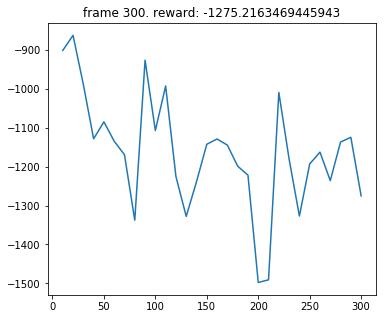

In [15]:
from types import MethodType

envs = ["Hover-v0", "RandomWaypoint-v0"]
episodes, returns = [], []
for e in envs:
    print("Initializing "+e)
    env = gym.make(e)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    hidden_dim = 256
    agent = SimpleREINFORCE(state_dim, hidden_dim, action_dim).to(device)
    agent.get_phi = MethodType(get_q, agent)
    opt = torch.optim.Adam(agent.parameters(), 1e-4)
    ep, rew = train_offline(agent, opt, env, batch_size=1024, iterations=300, epochs=1, log_interval=10)
    episodes.append(ep)
    returns.append(rew)
    torch.save(agent.state_dict(), "REINFORCE-"+e+"-q.pth.tar")
agent_episodes.append(episodes)
agent_rewards.append(returns)

#### 6.1.2 Using Generalized Advantage Estimation

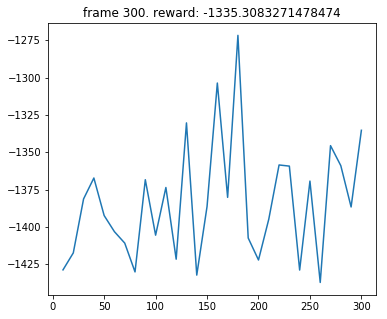

In [20]:
from types import MethodType

envs = ["Hover-v0", "RandomWaypoint-v0"]
episodes, returns = [], []
for e in envs:
    print("Initializing "+e)
    env = gym.make(e)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    hidden_dim = 256
    agent = SimpleREINFORCE(state_dim, hidden_dim, action_dim).to(device)
    agent.get_phi = MethodType(get_gae, agent)
    opt = torch.optim.Adam(agent.parameters(), 1e-4)
    ep, rew = train_offline(agent, opt, env, batch_size=1024, iterations=300, epochs=1, log_interval=10)
    episodes.append(ep)
    returns.append(rew)
    torch.save(agent.state_dict(), "REINFORCE-"+e+"-gae.pth.tar")
agent_episodes.append(episodes)
agent_rewards.append(returns)

#### 6.1.3 Using the Empirical Q Function with Bootstrapping

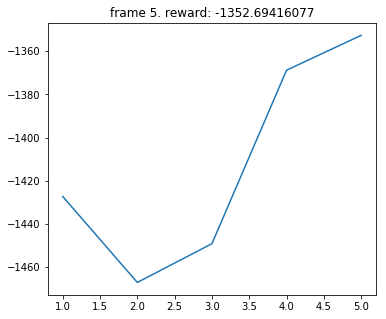

In [17]:
from types import MethodType

envs = ["Hover-v0", "RandomWaypoint-v0"]
episodes, returns = [], []
for e in envs:
    print("Initializing "+e)
    env = gym.make(e)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    hidden_dim = 256
    agent = SimpleREINFORCE(state_dim, hidden_dim, action_dim).to(device)
    agent.get_phi = MethodType(get_peb_q, agent)
    opt = torch.optim.Adam(agent.parameters(), 1e-4)
    ep, rew = train_offline(agent, opt, env, batch_size=1024, iterations=300, epochs=1, log_interval=10)
    episodes.append(ep)
    returns.append(rew)
    torch.save(agent.state_dict(), "REINFORCE-"+e+"-peb_q.pth.tar")
agent_episodes.append(episodes)
agent_rewards.append(returns)

#### 6.1.4 Using Generalized Advantage Estimation with Bootstrapping

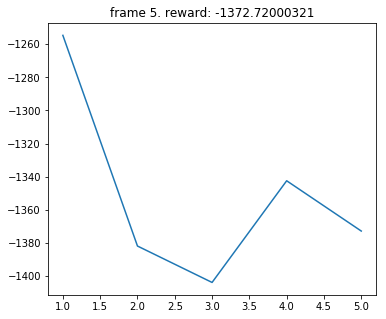

In [11]:
from types import MethodType

envs = ["Hover-v0", "RandomWaypoint-v0"]
episodes, returns = [], []
for e in envs:
    env = gym.make(e)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    hidden_dim = 256
    agent = SimpleREINFORCE(state_dim, hidden_dim, action_dim).to(device)
    agent.get_phi = MethodType(get_peb_gae, agent)
    opt = torch.optim.Adam(agent.parameters(), 1e-4)
    ep, rew = train_offline(agent, opt, env, batch_size=1024, iterations=300, epochs=1, log_interval=10)
    episodes.append(ep)
    returns.append(rew)
    torch.save(agent.state_dict(), "REINFORCE-"+e+"-peb_gae.pth.tar")
agent_episodes.append(episodes)
agent_rewards.append(returns)

### 6.2 Proximal Policy Optimization
We use the following parameter settings for our implementation of PPO:

|Parameter Name        |Parameter Value|Unit|
|----------------------|:-------------:|----|
|Tau                   |1e-2           |N/A |
|Critic stepsize       |1e-4           |N/A |
|Goal threshold radius |0.1            |m   |
|Batch-size            |2048           |N/A |
|Iterations            |1000           |N/A |
|Network hidden layers |2              |N/A |
|Network hidden neurons|256            |N/A |

#### 6.2.1 Using the Empirical Q Function

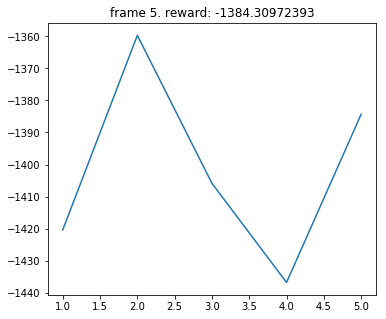

In [26]:
from types import MethodType

envs = ["Hover-v0", "RandomWaypoint-v0"]
episodes, returns = [], []
for e in envs:
    env = gym.make(e)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    hidden_dim = 256
    agent = SimplePPO(state_dim, hidden_dim, action_dim).to(device)
    agent.get_phi = MethodType(get_q, agent)
    opt = torch.optim.Adam(agent.parameters(), 1e-4)
    ep, rew = train_offline(agent, opt, env, batch_size=1024, iterations=300, epochs=4, log_interval=10)
    episodes.append(ep)
    returns.append(rew)
    torch.save(agent.state_dict(), "PPO-"+e+"-q.pth.tar")
agent_episodes.append(episodes)
agent_rewards.append(returns)

#### 6.2.2 Using Generalized Advantage Estimation

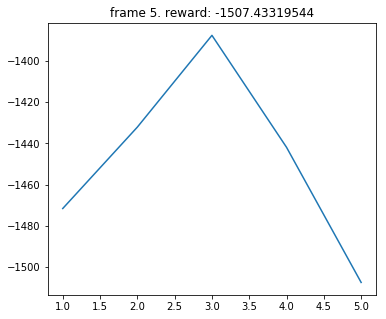

In [21]:
from types import MethodType

envs = ["Hover-v0", "RandomWaypoint-v0"]
episodes, returns = [], []
for e in envs:
    env = gym.make(e)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    hidden_dim = 256
    agent = SimplePPO(state_dim, hidden_dim, action_dim).to(device)
    agent.get_phi = MethodType(get_gae, agent)
    opt = torch.optim.Adam(agent.parameters(), 1e-4)
    ep, rew = train_offline(agent, opt, env, batch_size=1024, iterations=300, epochs=4, log_interval=10)
    episodes.append(ep)
    returns.append(rew)
    torch.save(agent.state_dict(), "PPO-"+e+".pth.tar")
agent_episodes.append(episodes)
agent_rewards.append(returns)

#### 6.2.3 Using the Empirical Q Function with Bootstrapping

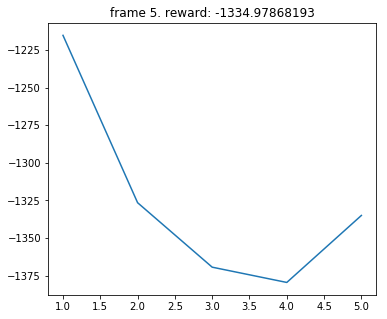

In [24]:
from types import MethodType

envs = ["Hover-v0", "RandomWaypoint-v0"]
episodes, returns = [], []
for e in envs:
    env = gym.make(e)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    hidden_dim = 256
    agent = SimplePPO(state_dim, hidden_dim, action_dim).to(device)
    agent.get_phi = MethodType(get_peb_q, agent)
    opt = torch.optim.Adam(agent.parameters(), 1e-4)
    ep, rew = train_offline(agent, opt, env, batch_size=1024, iterations=300, epochs=4, log_interval=10)
    episodes.append(ep)
    returns.append(rew)
    torch.save(agent.state_dict(), "PPO-"+e+"-peb_q.pth.tar")
agent_episodes.append(episodes)
agent_rewards.append(returns)

#### 6.2.4 Using Generalized Advantage Estimation with Bootstrapping

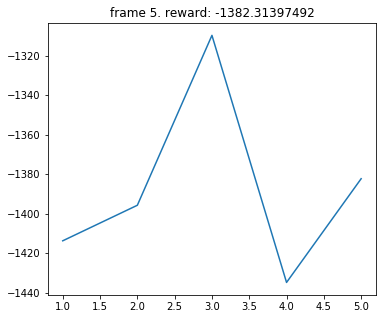

In [25]:
from types import MethodType

envs = ["Hover-v0", "RandomWaypoint-v0"]
episodes, returns = [], []
for e in envs:
    env = gym.make(e)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    hidden_dim = 256
    agent = SimplePPO(state_dim, hidden_dim, action_dim).to(device)
    agent.get_phi = MethodType(get_peb_gae, agent)
    opt = torch.optim.Adam(agent.parameters(), 1e-4)
    ep, rew = train_offline(agent, opt, env, batch_size=1024, iterations=300, epochs=4, log_interval=10)
    episodes.append(ep)
    returns.append(rew)
    torch.save(agent.state_dict(), "PPO-"+e+"-peb_gae.pth.tar")
agent_episodes.append(episodes)
agent_rewards.append(returns)

### 6.3 Trust Region Policy Optimization
We use the following parameter settings for our implementation of TRPO:

|Parameter Name        |Parameter Value|Unit|
|----------------------|:-------------:|----|
|KL-Divergence         |1e-2           |N/A |
|Tau                   |1e-2           |N/A |
|Critic stepsize       |1e-4           |N/A |
|Goal threshold radius |0.1            |m   |
|Batch-size            |2048           |N/A |
|Iterations            |1000           |N/A |
|Network hidden layers |2              |N/A |
|Network hidden neurons|256            |N/A |

#### 6.3.1 Using the Empirical Q Function

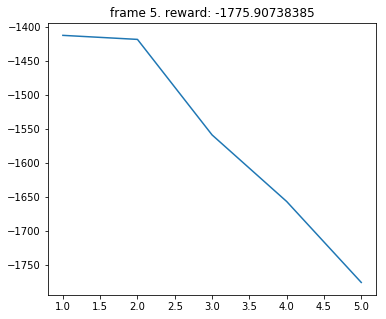

In [21]:
from types import MethodType

envs = ["Hover-v0", "RandomWaypoint-v0"]
episodes, returns = [], []
for e in envs:
    env = gym.make(e)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    hidden_dim = 256
    agent = SimpleTRPO(state_dim, hidden_dim, action_dim).to(device)
    agent.get_phi = MethodType(get_q, agent)
    opt = torch.optim.Adam(agent.parameters(), 1e-4)
    ep, rew = train_offline(agent, opt, env, batch_size=5, iterations=5, log_interval=1)
    episodes.append(ep)
    returns.append(rew)
    torch.save(agent.state_dict(), "TRPO-"+e+"-q.pth.tar")
agent_episodes.append(episodes)
agent_rewards.append(returns)

#### 6.3.2 Using Generalized Advantage Estimation

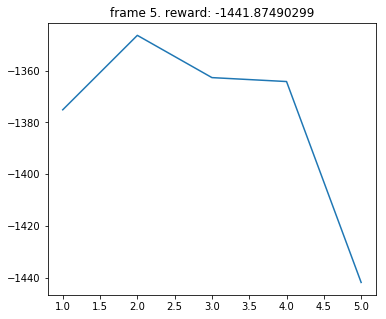

In [22]:
from types import MethodType

envs = ["Hover-v0", "RandomWaypoint-v0"]
episodes, returns = [], []
for e in envs:
    env = gym.make(e)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    hidden_dim = 256
    agent = SimpleTRPO(state_dim, hidden_dim, action_dim).to(device)
    agent.get_phi = MethodType(get_gae, agent)
    opt = torch.optim.Adam(agent.parameters(), 1e-4)
    ep, rew = train_offline(agent, opt, env, batch_size=5, iterations=5, log_interval=1)
    episodes.append(ep)
    returns.append(rew)
    torch.save(agent.state_dict(), "TRPO-"+e+".pth.tar")
agent_episodes.append(episodes)
agent_rewards.append(returns)

#### 6.3.3 Using the Empirical Q Function with Bootstrapping

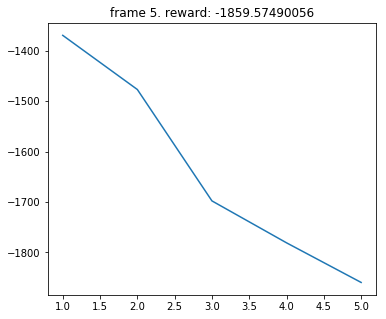

In [23]:
from types import MethodType

envs = ["Hover-v0", "RandomWaypoint-v0"]
episodes, returns = [], []
for e in envs:
    env = gym.make(e)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    hidden_dim = 256
    agent = SimpleTRPO(state_dim, hidden_dim, action_dim).to(device)
    agent.get_phi = MethodType(get_peb_q, agent)
    opt = torch.optim.Adam(agent.parameters(), 1e-4)
    ep, rew = train_offline(agent, opt, env, batch_size=5, iterations=5, log_interval=1)
    episodes.append(ep)
    returns.append(rew)
    torch.save(agent.state_dict(), "TRPO-"+e+"-peb_q.pth.tar")
agent_episodes.append(episodes)
agent_rewards.append(returns)

#### 6.3.4 Using Generalized Advantage Estimation with Bootstrapping

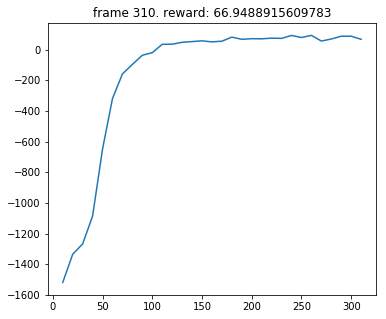

KeyboardInterrupt: 

In [11]:
from types import MethodType

envs = ["RandomWaypoint-v0"]
episodes, returns = [], []
for e in envs:
    env = gym.make(e)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    hidden_dim = 256
    agent = SimpleTRPO(state_dim, hidden_dim, action_dim).to(device)
    agent.get_phi = MethodType(get_peb_gae, agent)
    opt = torch.optim.Adam(agent.parameters(), 1e-4)
    ep, rew = train_offline(agent, opt, env, batch_size=4096, iterations=500, log_interval=10)
    episodes.append(ep)
    returns.append(rew)
    torch.save(agent.state_dict(), "TRPO-"+e+"-peb_gae.pth.tar")
agent_episodes.append(episodes)
agent_rewards.append(returns)

In [10]:
env_name = "RandomWaypoint-v0"
env_one = gym.make(env_name)

state_dim = env_one.observation_space.shape[0]
action_dim = env_one.action_space.shape[0]
hidden_dim = 256

fname = "TRPO-"+env_name+"-peb_gae.pth.tar"
agent_check = SimpleTRPO(state_dim, hidden_dim, action_dim).to(device)
agent_check.load_state_dict(torch.load("./"+fname))
_ = rollout(agent_check, env_one, 2048, render=True)

[2019-06-24 11:19:15,179] Making new env: RandomWaypoint-v0


Simulation parameters:
Aircraft mass:  0.6499999761581421
Gravity:  9.8100004196167
Torque coefficient:  7.500000265281415e-07
Thrust coefficient:  3.1299998227041215e-05
Maximum RPM:  3047.722428374999
Hover RPM:  2155.0651962782936
Hover Omega:  225.6778996211644


### 6.4 Online Agents
#### 6.4.1 Deep Deterministic Policy Gradient
We use the following parameter settings for our implementation of DDPG:

|Parameter Name        |Parameter Value|Unit|
|----------------------|:-------------:|----|
|KL-Divergence         |1e-2           |N/A |
|Tau                   |1e-2           |N/A |
|Critic stepsize       |1e-4           |N/A |
|Goal threshold radius |0.1            |m   |
|Batch-size            |2048           |N/A |
|Iterations            |1000           |N/A |
|Network hidden layers |2              |N/A |
|Network hidden neurons|256            |N/A |

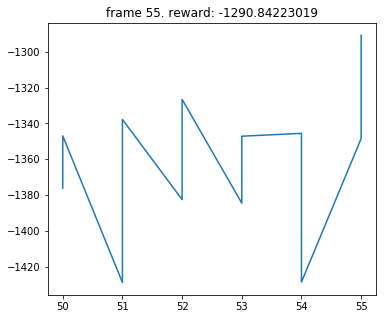

In [26]:
envs = ["Hover-v0", "RandomWaypoint-v0"]
episodes, returns = [], []
for e in envs:
    env = gym.make(e)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    hidden_dim = 256
    agent = SimpleDDPG(state_dim, hidden_dim, action_dim).to(device)
    ep, rew = train_online(agent, env, iterations=5, batch_size=16, epochs=1, warmup=50, log_interval=1)
    episodes.append(ep)
    returns.append(rew)
    torch.save(agent.state_dict(), "DDPG-"+e+".pth.tar")
agent_episodes.append(episodes)
agent_rewards.append(returns)

#### 6.4.2 Soft Actor-Critic
We use the following parameter settings for our implementation of SAC:

|Parameter Name        |Parameter Value|Unit|
|----------------------|:-------------:|----|
|KL-Divergence         |1e-2           |N/A |
|Tau                   |1e-2           |N/A |
|Critic stepsize       |1e-4           |N/A |
|Goal threshold radius |0.1            |m   |
|Batch-size            |2048           |N/A |
|Iterations            |1000           |N/A |
|Network hidden layers |2              |N/A |
|Network hidden neurons|256            |N/A |

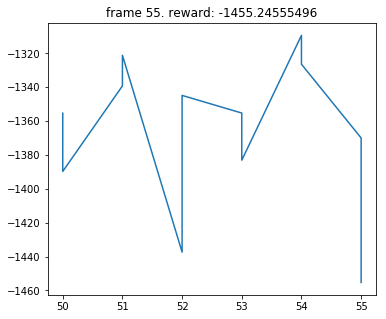

In [43]:
envs = ["Hover-v0", "RandomWaypoint-v0"]
episodes, returns = [], []
for e in envs:
    env = gym.make(e)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    hidden_dim = 256
    agent = SimpleSAC(state_dim, hidden_dim, action_dim).to(device)
    ep, rew = train_online(agent, env, iterations=5, batch_size=16, epochs=1, warmup=50, log_interval=1)
    episodes.append(ep)
    returns.append(rew)
    torch.save(agent.state_dict(), "SAC-"+e+".pth.tar")
agent_episodes.append(episodes)
agent_rewards.append(returns)

### 6.5 Comparison of Algorithms
We plot the results of the above experiments below so that agents can be quantitatively compared with one another:

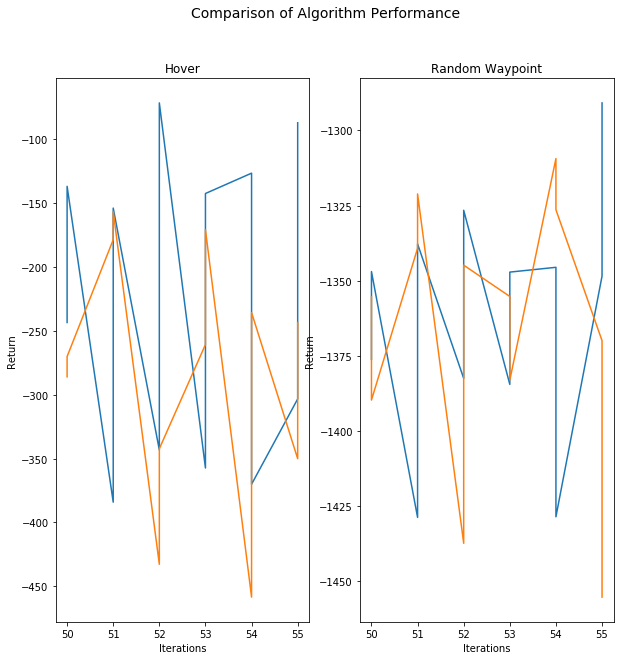

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
fig.suptitle("Comparison of Algorithm Performance", fontsize=14)

ax1.set_title("Hover")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Return")

ax2.set_title("Random Waypoint")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Return")

for alg_ep, alg_rew in zip(agent_episodes, agent_rewards):
    ax1.plot(alg_ep[0], alg_rew[0])
    ax2.plot(alg_ep[1], alg_rew[1])
    
plt.show()

### 6.6 Comparison of Action Selection Methods
Below, we show that the above methods don't learn to cover the action space effectively. That is, though they are able to learn the tasks above, they don't learn to cover the full space. We can make this explicit by trying to train an agent on a task that requires going from hover to full throttle, and showing that the agent never actually learns to complete the task. We will use TRPO with GAE and bootstrapping for this task, as it was the best performing agent in the previous experiments.

In [ ]:
from types import MethodType

env_name = "Loop-v0"
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 256
agent = SimpleTRPO(state_dim, hidden_dim, action_dim)
agent.get_phi = MethodType(get_peb_gae, agent)
opt = torch.optim.Adam(agent.parameters(), 1e-4)
ep, rew = train_offline(agent, opt, env, batch_size=2048, iterations=300, log_interval=10)
torch.save(agent.state_dict(), "TRPO-"+env_name+"-peb_gae.pth.tar")

This is problematic, because we may eventually want to learn tasks for which we need to cover the full spectrum of possible actions. We can make a quick observation that -- since our expected action is roughly hover, and our motor thrust is modelled as being quadratic -- roughly $\frac{1}{\sqrt{2}}\approx 70\%$ of our actions will result in loss of altitude, while only $\approx 30\%$ will gain altitude. We counteracted this earlier by linearizing actions around the hover RPM. If we choose a different action selection method, we might be able to sample more uniformly from this space whilst still allowing the agent to easily cover the full spectrum of possible actions.

We try the following:

\begin{equation}
F_T = k_T\Omega^2
\end{equation}

\begin{equation}
\Omega = \Omega_\max\sqrt{\sigma(x)}
\end{equation}

Where $\sigma$ is the logit function output of the network. We can interpret this as agent outputting the percentage throttle, which we then bias using the square root function, and multiply by the maximum RPM to get the action.

We implement this in code below:

In [ ]:
def select_action_offline(self, x):
    mu, logvar = self.beta(x)
    mu = torch.sqrt(F.sigmoid(mu))
    sigma = logvar.exp().sqrt()
    dist = Normal(mu, sigma)
    action = dist.sample()
    log_prob = dist.log_prob(action)
    value = self.critic(x)
    return action, log_prob, value

def select_action_online(self, x):
    mu, logvar = self.actor(x)
    mu = torch.sqrt(F.sigmoid(mu))
    sigma = logvar.exp().sqrt()
    dist = Normal(mu, sigma)
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return action, log_prob

def translate_action(self, action):
    return action

Now we'll run the same experiment as above using both the old and new action selection methods to see if there's any difference in the coverage of the action space:

In [ ]:
from types import MethodType

env_name = "Loop-v0"
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 256
agent = SimpleTRPO(state_dim, hidden_dim, action_dim)
agent.get_phi = MethodType(get_peb_gae, agent)
agent.translate_action = MethodType(translate_action, agent)
opt = torch.optim.Adam(agent.parameters(), 1e-4)
ep, rew = train_offline(agent, opt, env, batch_size=2048, iterations=300, log_interval=10)
torch.save(agent.state_dict(), "TRPO-"+env_name+"-peb_gae.pth.tar")

As we can see...

### 6.7 Including Time in the Observation Space
For this series of experiments, we include time in the observation space. There are a few reasons for including this:
1. Quadrotor control is a continuing task. Similar with including bootstrapping, ...
2. We might learn more general flight control policies by modulating the action with the desired time. I.e. this gives us a way of controlling speed.

In [ ]:
def step(self, action):
    for _ in self.steps:
            xyz, zeta, uvw, pqr = self.iris.step(self.trim_np+action*self.bandwidth)
    sin_zeta = np.sin(zeta)
    cos_zeta = np.cos(zeta)
    current_rpm = (self.iris.get_rpm()/self.action_bound[1]).tolist()
    next_position = xyz.T.tolist()[0]
    next_attitude = sin_zeta.T.tolist()[0]+cos_zeta.T.tolist()[0]
    next_velocity = uvw.T.tolist()[0]+pqr.T.tolist()[0]
    next_state = next_position+next_attitude+next_velocity
    info = self.reward((xyz, zeta, uvw, pqr), action)
    done = self.terminal((xyz, zeta))
    reward = sum(info)
    position_goal = self.vec_xyz.T.tolist()[0]
    attitude_goal = self.vec_zeta_sin.T.tolist()[0]+self.vec_zeta_cos.T.tolist()[0]
    velocity_goal = self.vec_uvw.T.tolist()[0]+self.vec_pqr.T.tolist()[0]
    goals = position_goal+attitude_goal+velocity_goal
    self.t += 1
    next_state = next_state+current_rpm+goals+[self.T-self.t*self.ctrl_dt]
    self.prev_action = action
    self.prev_uvw = uvw
    self.prev_pqr = pqr
    return next_state, reward, done, {"dist_rew": info[0], 
                                        "att_rew": info[1], 
                                        "vel_rew": info[2], 
                                        "ang_rew": info[3], 
                                        "ctrl_rew": info[4], 
                                        "time_rew": info[5], 
                                        "cmplt_rew": info[6]}

def reset(self):
    self.t = 0
    self.T = 3.5
    xyz, zeta, uvw, pqr = self.iris.reset()
    self.iris.set_rpm(np.array(self.trim))
    self.goal_xyz = self.generate_goal()
    sin_zeta = np.sin(zeta)
    cos_zeta = np.cos(zeta)
    current_rpm = (self.iris.get_rpm()/self.action_bound[1]).tolist()
    self.prev_action = self.trim_np.copy()
    self.prev_uvw = np.array([[0.],[0.],[0.]])
    self.prev_pqr = np.array([[0.],[0.],[0.]])
    next_position = xyz.T.tolist()[0]
    next_attitude = sin_zeta.T.tolist()[0]+cos_zeta.T.tolist()[0]
    next_velocity = uvw.T.tolist()[0]+pqr.T.tolist()[0]  
    next_state = next_position+next_attitude+next_velocity
    self.vec_xyz = xyz-self.goal_xyz
    self.vec_zeta_sin = sin_zeta
    self.vec_zeta_cos = cos_zeta
    self.vec_uvw = uvw
    self.vec_pqr = pqr
    self.dist_norm = np.linalg.norm(self.vec_xyz)
    self.att_norm_sin = np.linalg.norm(self.vec_zeta_sin)
    self.att_norm_cos = np.linalg.norm(self.vec_zeta_cos)
    self.vel_norm = np.linalg.norm(self.vec_uvw)
    self.ang_norm = np.linalg.norm(self.vec_pqr)
    position_goal = self.vec_xyz.T.tolist()[0]
    attitude_goal = self.vec_zeta_sin.T.tolist()[0]+self.vec_zeta_cos.T.tolist()[0]
    velocity_goal = self.vec_uvw.T.tolist()[0]+self.vec_pqr.T.tolist()[0]
    goals = position_goal+attitude_goal+velocity_goal
    next_state = next_state+current_rpm+goals+[self.T-self.t*self.ctrl_dt]
    return next_state

Next, we'll try running our experiments including time in the observation space:

In [ ]:
from types import MethodType

env_name = "Hover-v0"
env = gym.make(env_name)
env.T = None
env.t = 0
env.observation_space = None
env.action_space = None
env.step = MethodType(step, env)
env.reset = MethodType(reset, env)
env.translate_action = MethodType(translate_action, env)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 256

agent = SimpleTRPO(state_dim, hidden_dim, action_dim)
agent.get_phi = MethodType(get_peb_gae, agent)
opt = torch.optim.Adam(agent.parameters(), 1e-4)
ep, rew = train_offline(agent, opt, env, batch_size=2048, iterations=300, log_interval=10)
torch.save(agent.state_dict(), "TRPO-"+env_name+"-peb_gae-time.pth.tar")

### 6.8 The Effect of Action Selection Frequency
Finally, we'll explore the effect of action selection frequency on the performance of the agent. This is critical in an environment such as quadrotors in which the platform is inherently unstable. Logically, very low action selection frequencies should learn, but converge to a low return. High action selection frequencies are also likely to produce poor behavior, since the discount factor results in a very short term horizon.

In [ ]:
from types import MethodType

ctrl_dts = [0.01, 0.05, 0.1, 0.15, 0.2]
env_name = "Hover-v0"
env = gym.make(env_name)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 256
eps, rews = [], []
for cdt in ctrl_dts:
    env.ctrl_dt = cdt
    agent = SimpleTRPO(state_dim, hidden_dim, action_dim)
    agent.get_phi = MethodType(get_peb_gae, agent)
    opt = torch.optim.Adam(agent.parameters(), 1e-4)
    ep, rew = train_offline(agent, opt, env, batch_size=2048, iterations=300, log_interval=10)
    torch.save(agent.state_dict(), "TRPO-"+env_name+"-"+str(cdt)+"s-peb_gae.pth.tar")
    eps.append(ep)
    rews.append(rew)

As we can see, there is an optimal action selection frequency, with very fast agents not learning to control the aircraft adequately, and very slow agents not able to counteract the instability of the system. One solution to this that was used in [] is to train the agent at a lower frequency, but then run it at a higher frequency. As we can see below, this is effective, and produces slightly better performance than when the agent is run at the same frequency it was trained at:

In [ ]:
env_name = "Hover-v0"
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 256
agent = SimpleTRPO(state_dim, hidden_dim, action_dim)
agent.get_phi = MethodType(get_peb_gae, agent)
agent.load_state_dict(torch.load("TRPO-"+env_name+"-0.05s-peb_gae.pth.tar"))

print("Testing agent trained at 0.05s ctrl freq at 0.05s ctrl_freq:")
env.ctrl_dt = 0.05
test_rew = np.mean([test_offline(agent, env) for _ in range(10)])
print("Mean return: ", test_rew)
print()
print("Testing agent trained at 0.05s ctrl freq at 0.01s ctrl_freq:")
env.ctrl_dt = 0.01
test_rew = np.mean([test_offline(agent, env) for _ in range(10)])
print("Mean return: ", test_rew)

## 7. Discussion

### 7.1 Online vs. Offline Algorithms
We show that in general, online algorithms seem to fare worse than offline algorithms when training agents to perform basic quadrotor flight tasks. We believe that one of the reasons for this is the inherent instability of the platform. In the case of offline algorithms, they are able to make an estimate of the return of the policy over many trajectories, which gives them a better estimate of the gradient. In the case of the online algorithms, they start off with a bad policy, and take time to "burn-in" since any updates to the policy may take it to a new region that the value function then has to be trained on.